In [3]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("white")

pandas2ri.activate()

from PyCROSL import SubstrateReal, AbsObjectiveFunc, CRO_SL
import random
from objective_functions import *

%matplotlib inline

rscript_name_single = "exec_optim.R"
rscript_name_cascade = "exec_optim_semidist.R"

In [4]:
basin_n = 5043  # 3005 or 5043

if basin_n == 3005:
    data_file = "data/data_CHT_SIMPA_cal.csv"
    basin_file = "data/basins_CHT.csv"
elif basin_n == 5043:
    data_file = "data/data_CHG_SIMPA_cal.csv"
    basin_file = "data/basins_CHG.csv"
else:
    raise Exception("Invalid basin.")

In [5]:
# Defining the R script and loading the instance in Python
r = robjects.r
r["source"](rscript_name_single)
r["source"](rscript_name_cascade)

robjects.globalenv["init_global"](data_file, basin_file)
robjects.globalenv["init_global_single"](data_file, basin_file, basin_n)
exec_function_single_r = robjects.globalenv["eval_basin_param_single"]
exec_function_r = robjects.globalenv["eval_basin_param"]
get_basin_q = robjects.globalenv["get_basin_q"]

weights = []
basin_df = pd.read_csv(basin_file)
basin_df.sort_values(by=["order"])

full_data = pd.read_csv(data_file)
for i, idx in enumerate(basin_df.index):
    basin_code = basin_df["code"][idx]
    total_caudal = full_data[full_data["qhmobs"] != -100][full_data["code"] == basin_n]["qhmobs"].sum()
    weights.append(total_caudal)
print(weights)
weights = np.asarray(weights) / sum(weights)
print(weights)

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: hydroGOF

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[np.float64(6328.447400000001), np.float64(6328.447400000001), np.float64(6328.447400000001), np.float64(6328.447400000001), np.float64(6328.447400000001)]
[0.2 0.2 0.2 0.2 0.2]


/tmp/ipykernel_83728/1066140088.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_caudal = full_data[full_data["qhmobs"] != -100][full_data["code"] == basin_n]["qhmobs"].sum()
/tmp/ipykernel_83728/1066140088.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_caudal = full_data[full_data["qhmobs"] != -100][full_data["code"] == basin_n]["qhmobs"].sum()
/tmp/ipykernel_83728/1066140088.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_caudal = full_data[full_data["qhmobs"] != -100][full_data["code"] == basin_n]["qhmobs"].sum()
/tmp/ipykernel_83728/1066140088.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_caudal = full_data[full_data["qhmobs"] != -100][full_data["code"] == basin_n]["qhmobs"].sum()
/tmp/ipykernel_83728/1066140088.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_caudal = 

In [6]:
# result_path = "results/new_data/"
result_path = ""
exec_types = [
    ("single", "MSE", 0),
    ("cascade", "MSE", 0),
    ("full", "MSE", 0),
    ("fullpon", "MSE", 0),
]

result_files = [(f"./{result_path}config_{problem_type}_{basin_n}_{model}_{metric}.csv", problem_type, model, metric) for problem_type, metric, model in exec_types]

for file_name, *_ in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if not os.path.exists(file_name):
        raise Exception("Some files were not found.")

./config_single_5043_0_MSE.csv Yes
./config_cascade_5043_0_MSE.csv Yes
./config_full_5043_0_MSE.csv Yes
./config_fullpon_5043_0_MSE.csv Yes


In [7]:
print(np.loadtxt(result_files[0][0], delimiter=",", max_rows=1).shape)

(7,)


In [8]:
eval_df = pd.DataFrame(columns=["type", "model", "target", "basin_code", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE", "params"])
params_list = []
for file_name, problem_type, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if problem_type == "single":
        params = np.loadtxt(file_name, delimiter=",", max_rows=1)
        params_list.append(",".join(map(str, params)))

        metrics = exec_function_single_r(model, params)
        param_str = np.array2string(params, max_line_width=np.inf, separator=";").replace(" ", "")
        eval_df.loc[len(eval_df)] = [problem_type, model, target, basin_n] + list(metrics) + [param_str]
    elif problem_type in ["cascade"]:
        params = np.loadtxt(file_name, delimiter=",").reshape([len(basin_df), -1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]

            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]

            if codedown not in agg_q:
                agg_q[codedown] = 0

            # agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)
            agg_q_aux = get_basin_q(model, params[idx], basin_code, prev_q)
            agg_q[codedown] += agg_q_aux

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [problem_type, model, target, basin_code] + list(metrics) + [param_str]
    
    elif problem_type in ["full", "fullpon", "cascade"]:
        params = np.loadtxt(file_name, delimiter=",", max_rows=1).reshape([len(basin_df), -1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]

            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]

            if codedown not in agg_q:
                agg_q[codedown] = 0

            agg_q_aux = get_basin_q(model, params[idx], basin_code, prev_q)
            agg_q[codedown] += agg_q_aux

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [problem_type, model, target, basin_code] + list(metrics) + [param_str]
    

eval_df = eval_df[eval_df["target"] != "R2"]
eval_df

./config_single_5043_0_MSE.csv Yes
./config_cascade_5043_0_MSE.csv Yes
./config_full_5043_0_MSE.csv Yes
./config_fullpon_5043_0_MSE.csv Yes


,type,model,target,basin_code,MSE,RMSE,Pbias,NSE,R2,KGE,params
0,single,0,MSE,5043,1288.533178,35.896144,783.2,0.115429,0.083055,-24.784497,[6.52772847e-01;1.50596867e+03;6.19913017e-01;...
1,cascade,0,MSE,5029,19.468695,4.412334,64.7,0.957152,0.621018,0.569132,[9.45854451e-01;7.99150955e+02;0.00000000e+00;...
2,cascade,0,MSE,5054,0.106642,0.326561,78.6,0.611913,0.553241,0.548373,[9.96092326e-01;5.01632075e+02;6.39588167e-01;...
3,cascade,0,MSE,5060,0.888273,0.942483,39.4,0.920655,0.812110,0.785194,[9.69567673e-01;4.25563982e+02;5.84919571e-01;...
4,cascade,0,MSE,5071,4.813339,2.193932,36.7,0.965870,0.811778,0.761105,[5.61404950e-01;7.33900343e+02;9.99804862e-01;...
5,cascade,0,MSE,5043,122.445845,11.065525,82.4,1.128683,0.594890,-0.035744,[9.85793577e-01;1.00992190e+03;1.00000000e+00;...
6,full,0,MSE,5029,23.888990,4.887636,71.7,0.700301,0.571681,0.469652,[8.81016748e-01;3.93763993e+02;9.31777679e-01;...
7,full,0,MSE,5054,0.182043,0.426665,102.7,0.000000,0.630375,0.229053,[1.00000000e+00;1.51568071e+03;2.41438072e-01;...
8,full,0,MSE,5060,1.464148,1.210020,50.6,0.870401,0.716784,0.645894,[9.87181708e-01;5.06688648e+02;7.04469501e-01;...
9,full,0,MSE,5071,9.298004,3.049263,51.1,0.747440,0.699331,0.543589,[5.48716951e-01;1.35716016e+03;4.81067644e-01;...


In [9]:
eval_df.sort_values("NSE")

,type,model,target,basin_code,MSE,RMSE,Pbias,NSE,R2,KGE,params
7,full,0,MSE,5054,0.182043,0.426665,102.7,0.000000,0.630375,0.229053,[1.00000000e+00;1.51568071e+03;2.41438072e-01;...
0,single,0,MSE,5043,1288.533178,35.896144,783.2,0.115429,0.083055,-24.784497,[6.52772847e-01;1.50596867e+03;6.19913017e-01;...
2,cascade,0,MSE,5054,0.106642,0.326561,78.6,0.611913,0.553241,0.548373,[9.96092326e-01;5.01632075e+02;6.39588167e-01;...
14,fullpon,0,MSE,5071,18.915996,4.349252,72.8,0.645079,0.510563,0.074901,[9.36593765e-02;1.32412363e+03;9.96332627e-01;...
13,fullpon,0,MSE,5060,10.929513,3.305981,138.3,0.680556,0.264085,-1.637887,[8.07843916e-01;4.79244730e+02;9.98752280e-01;...
6,full,0,MSE,5029,23.888990,4.887636,71.7,0.700301,0.571681,0.469652,[8.81016748e-01;3.93763993e+02;9.31777679e-01;...
11,fullpon,0,MSE,5029,20.998991,4.582466,67.2,0.740131,0.612136,0.534827,[9.33728329e-01;5.21590858e+02;7.75930588e-01;...
9,full,0,MSE,5071,9.298004,3.049263,51.1,0.747440,0.699331,0.543589,[5.48716951e-01;1.35716016e+03;4.81067644e-01;...
15,fullpon,0,MSE,5043,70.739808,8.410696,62.6,0.839506,0.636716,0.402972,[9.99972635e-01;4.07254786e+02;8.54524642e-01;...
8,full,0,MSE,5060,1.464148,1.210020,50.6,0.870401,0.716784,0.645894,[9.87181708e-01;5.06688648e+02;7.04469501e-01;...


In [10]:
# code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,param
# eval_df["code"] = 5043
# eval_df["order"] = 1
# eval_df["codedown"] = 0
# eval_df["supha"] = 329429.24
# eval_df["f0"] = -100
# eval_df["PBIAS"] = -100
# eval_sel_df = eval_df[eval_df["basin_code"] == basin_n]
eval_sel_df = eval_df.copy()
eval_sel_df["code"] = eval_sel_df["basin_code"]
eval_sel_df["order"] = 0
eval_sel_df["codedown"] = 0
for idx, row in eval_sel_df.iterrows():
    curr_basin = basin_df[basin_df.code == eval_sel_df.iloc[idx]["code"]]
    eval_sel_df.at[idx, "order"] = basin_df[basin_df.code == eval_sel_df.iloc[idx]["code"]]["order"]
    eval_sel_df.at[idx, "codedown"] = basin_df[basin_df.code == eval_sel_df.iloc[idx]["code"]]["codedown"]

eval_sel_df["supha"] = 329429.24
eval_sel_df["PBIAS"] = eval_sel_df["Pbias"]
eval_sel_df["f0"] = -100
eval_table_df = eval_sel_df[["type", "code", "order", "codedown", "supha", "MSE", "RMSE", "PBIAS", "NSE", "R2", "KGE", "f0", "params"]]
eval_table_df.loc[:, "params"] = eval_table_df.loc[:, "params"].str.replace("[", "")
eval_table_df.loc[:, "params"] = eval_table_df.loc[:, "params"].str.replace("]", "")
eval_table_df

/tmp/ipykernel_83728/1539868533.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  eval_sel_df.at[idx, "order"] = basin_df[basin_df.code == eval_sel_df.iloc[idx]["code"]]["order"]
/tmp/ipykernel_83728/1539868533.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  eval_sel_df.at[idx, "codedown"] = basin_df[basin_df.code == eval_sel_df.iloc[idx]["code"]]["codedown"]


,type,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,params
0,single,5043,2,0,329429.24,1288.533178,35.896144,783.2,0.115429,0.083055,-24.784497,-100,6.52772847e-01;1.50596867e+03;6.19913017e-01;1...
1,cascade,5029,1,5043,329429.24,19.468695,4.412334,64.7,0.957152,0.621018,0.569132,-100,9.45854451e-01;7.99150955e+02;0.00000000e+00;4...
2,cascade,5054,1,5043,329429.24,0.106642,0.326561,78.6,0.611913,0.553241,0.548373,-100,9.96092326e-01;5.01632075e+02;6.39588167e-01;1...
3,cascade,5060,1,5043,329429.24,0.888273,0.942483,39.4,0.920655,0.812110,0.785194,-100,9.69567673e-01;4.25563982e+02;5.84919571e-01;3...
4,cascade,5071,1,5043,329429.24,4.813339,2.193932,36.7,0.965870,0.811778,0.761105,-100,5.61404950e-01;7.33900343e+02;9.99804862e-01;1...
5,cascade,5043,2,0,329429.24,122.445845,11.065525,82.4,1.128683,0.594890,-0.035744,-100,9.85793577e-01;1.00992190e+03;1.00000000e+00;2...
6,full,5029,1,5043,329429.24,23.888990,4.887636,71.7,0.700301,0.571681,0.469652,-100,8.81016748e-01;3.93763993e+02;9.31777679e-01;3...
7,full,5054,1,5043,329429.24,0.182043,0.426665,102.7,0.000000,0.630375,0.229053,-100,1.00000000e+00;1.51568071e+03;2.41438072e-01;3...
8,full,5060,1,5043,329429.24,1.464148,1.210020,50.6,0.870401,0.716784,0.645894,-100,9.87181708e-01;5.06688648e+02;7.04469501e-01;7...
9,full,5071,1,5043,329429.24,9.298004,3.049263,51.1,0.747440,0.699331,0.543589,-100,5.48716951e-01;1.35716016e+03;4.81067644e-01;7...


In [11]:
for problem_type, df_type in eval_table_df.groupby("type"):
    df_final_type = df_type.drop(columns="type")
    df_final_type.to_csv(f"table_{problem_type}_test.txt", index=False, quoting=csv.QUOTE_NONE)
    display(df_final_type)

,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,params
1,5029,1,5043,329429.24,19.468695,4.412334,64.7,0.957152,0.621018,0.569132,-100,9.45854451e-01;7.99150955e+02;0.00000000e+00;4...
2,5054,1,5043,329429.24,0.106642,0.326561,78.6,0.611913,0.553241,0.548373,-100,9.96092326e-01;5.01632075e+02;6.39588167e-01;1...
3,5060,1,5043,329429.24,0.888273,0.942483,39.4,0.920655,0.812110,0.785194,-100,9.69567673e-01;4.25563982e+02;5.84919571e-01;3...
4,5071,1,5043,329429.24,4.813339,2.193932,36.7,0.965870,0.811778,0.761105,-100,5.61404950e-01;7.33900343e+02;9.99804862e-01;1...
5,5043,2,0,329429.24,122.445845,11.065525,82.4,1.128683,0.594890,-0.035744,-100,9.85793577e-01;1.00992190e+03;1.00000000e+00;2...


,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,params
6,5029,1,5043,329429.24,23.888990,4.887636,71.7,0.700301,0.571681,0.469652,-100,8.81016748e-01;3.93763993e+02;9.31777679e-01;3...
7,5054,1,5043,329429.24,0.182043,0.426665,102.7,0.000000,0.630375,0.229053,-100,1.00000000e+00;1.51568071e+03;2.41438072e-01;3...
8,5060,1,5043,329429.24,1.464148,1.210020,50.6,0.870401,0.716784,0.645894,-100,9.87181708e-01;5.06688648e+02;7.04469501e-01;7...
9,5071,1,5043,329429.24,9.298004,3.049263,51.1,0.747440,0.699331,0.543589,-100,5.48716951e-01;1.35716016e+03;4.81067644e-01;7...
10,5043,2,0,329429.24,78.678368,8.870083,66.1,0.893440,0.633348,0.338261,-100,9.93879102e-01;1.98567889e+03;9.99481783e-01;9...


,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,params
11,5029,1,5043,329429.24,20.998991,4.582466,67.2,0.740131,0.612136,0.534827,-100,9.33728329e-01;5.21590858e+02;7.75930588e-01;3...
12,5054,1,5043,329429.24,7.864696,2.804406,675.1,2.671957,0.062402,-32.306695,-100,1.68492336e-02;1.34876795e+03;9.99691815e-01;5...
13,5060,1,5043,329429.24,10.929513,3.305981,138.3,0.680556,0.264085,-1.637887,-100,8.07843916e-01;4.79244730e+02;9.98752280e-01;6...
14,5071,1,5043,329429.24,18.915996,4.349252,72.8,0.645079,0.510563,0.074901,-100,9.36593765e-02;1.32412363e+03;9.96332627e-01;4...
15,5043,2,0,329429.24,70.739808,8.410696,62.6,0.839506,0.636716,0.402972,-100,9.99972635e-01;4.07254786e+02;8.54524642e-01;1...


,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,f0,params
0,5043,2,0,329429.24,1288.533178,35.896144,783.2,0.115429,0.083055,-24.784497,-100,6.52772847e-01;1.50596867e+03;6.19913017e-01;1...


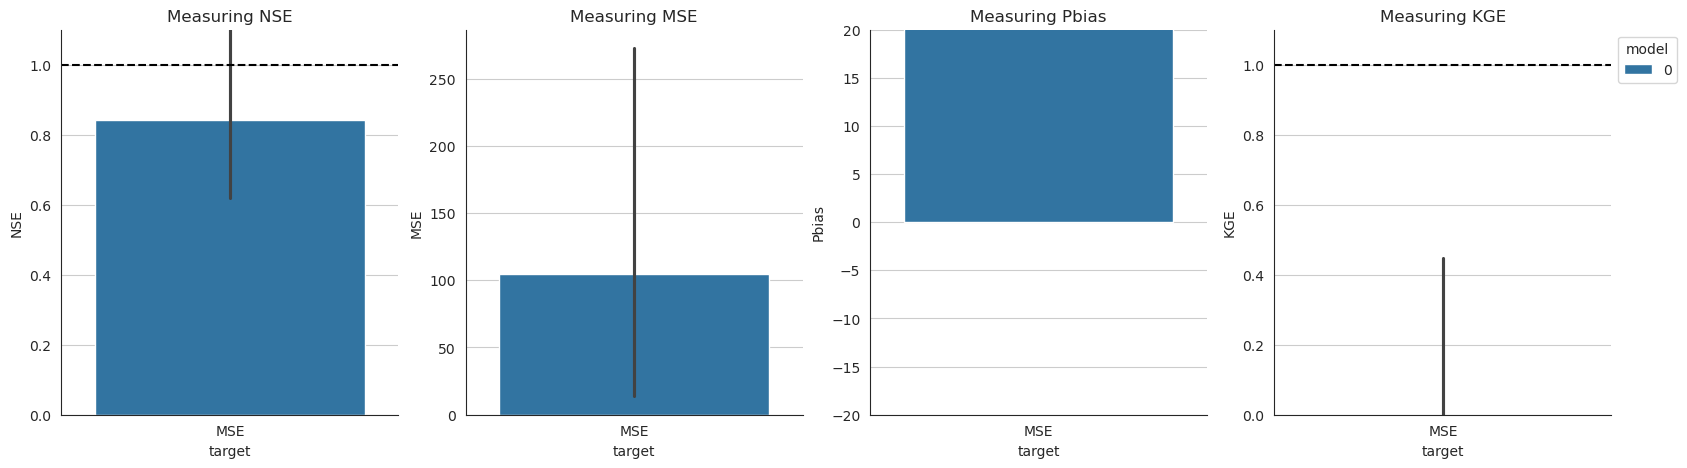

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))


metric_measures = ["NSE", "MSE", "Pbias", "KGE"]
for idx, metric in enumerate(["NSE", "MSE", "Pbias", "KGE"]):
    # ax = axes[idx//2, idx%2]
    ax = axes[idx]
    # hist_ax = sns.barplot(data=data_to_plot, x="target", y=metric_measure, hue="model", ax=ax)
    hist_ax = sns.barplot(data=eval_df, x="target", y=metric_measures[idx], hue="model", ax=ax)
    hist_ax.set(title=f"Measuring {metric}")

    if metric == "NSE":
        ax.axhline(1, color="k", linestyle="--")
        hist_ax.set(ylim=(0, 1.1))
    elif metric_measures[idx] == "Pbias":
        hist_ax.set(ylim=(-20, 20))
        pass
    elif metric != "MSE":
        ax.axhline(1, color="k", linestyle="--")
        hist_ax.set(ylim=(0, 1.1))

    if idx == 3:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    sns.despine()
    ax.grid(axis="y")

plt.show()